In [1]:
import sys
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import seaborn as sns
from h5py import File
import scienceplots

sys.path.insert(0, "/Users/rstiskalek/Projects/candel")
import candel
from utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2


COLS = "#1be7ffff", "#6eeb83ff", "#e4ff1aff", "#ffb800ff", "#ff5714ff", "#9b5de5ff",
root = join("/Users/rstiskalek/Projects/CANDEL/", "results", "VFO")

### Figure: Redshift distribution comparison

In [ ]:
import seaborn as sns
from candel import SPEED_OF_LIGHT


with File("/Users/rstiskalek/Projects/CANDEL/data/2MTF/PV_compilation.hdf5", 'r') as f:
    SFI = {}
    for key in f["SFI_gals"].keys():
        SFI[key] = f["SFI_gals"][key][...]

    TWOMTF = {}
    for key in f["2MTF"].keys():
        TWOMTF[key] = f["2MTF"][key][...]

    FOUNDATION = {}
    for key in f["Foundation"].keys():
        FOUNDATION[key] = f["Foundation"][key][...]

    LOSS = {}
    for key in f["LOSS"].keys():
        LOSS[key] = f["LOSS"][key][...]



with File("/Users/rstiskalek/Projects/CANDEL/data/CF4/CF4_TFR.hdf5", 'r') as f:
    CF4_TFR = {}
    grp = f["cf4"]
    for key in grp.keys():
        CF4_TFR[key] = grp[key][...]

    RA = grp["RA"][...] * 360 / 24
    CF4_TFR["RA"] = RA
    CF4_TFR["DEC"] = grp["DE"][...]

    l, b = candel.radec_to_galactic(CF4_TFR["RA"], CF4_TFR["DE"])
    m = np.abs(b) > 7.5
    for key in CF4_TFR.keys():
        CF4_TFR[key] = CF4_TFR[key][m]

In [ ]:
cols = COLS

with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10/3, 3), sharex=True)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    bins = np.linspace(0, 0.07, 30)
    alpha = 0.5
    edge_width = 1.0

    # First row: Foundation and LOSS
    sns.histplot(FOUNDATION["z_CMB"], bins=bins, stat="count", alpha=alpha, label="Foundation", color=cols[1], edgecolor="black", ax=axes[0], linewidth=edge_width)
    sns.histplot(LOSS["z_CMB"], bins=bins, stat="count", alpha=alpha, label="LOSS", color=cols[0], edgecolor="black", ax=axes[0], linewidth=edge_width)
    axes[0].set_ylabel(None)
    axes[0].legend()

    # Second row: 2MTF and SFI
    sns.histplot(SFI["z_CMB"], bins=bins, stat="count", alpha=alpha, label="SFI", color=cols[2], edgecolor="black", ax=axes[1], linewidth=edge_width)
    sns.histplot(TWOMTF["z_CMB"], bins=bins, stat="count", alpha=alpha, label="2MTF", color=cols[3], edgecolor="black", ax=axes[1], linewidth=edge_width)
    axes[1].set_ylabel(None)
    axes[1].legend()

    # Third row: CF4 samples
    m_i = CF4_TFR["i"] > 5
    sns.histplot(CF4_TFR["Vcmb"][m_i] / SPEED_OF_LIGHT, 
                 bins=bins, stat="count", alpha=alpha, label=catalogue2label("CF4_TFR_i"), color=cols[4], edgecolor="black", ax=axes[2], linewidth=edge_width)
    m_w1 = CF4_TFR["w1"] > 5
    sns.histplot(CF4_TFR["Vcmb"][m_w1] / SPEED_OF_LIGHT, 
                 bins=bins, stat="count", alpha=alpha, label=catalogue2label("CF4_TFR_w1"), color=cols[5], edgecolor="black", ax=axes[2], linewidth=edge_width)
    axes[2].set_xlabel(r"$z_{\rm obs}$")
    axes[2].set_ylabel(None)
    axes[2].legend()

    fig.text(0.03, 0.5, "Counts", va='center', ha='center', rotation='vertical')

    # Adjust layout
    plt.xlim(0, 0.07)
    plt.tight_layout(w_pad=0.2, h_pad=0.2)
    plt.savefig(f"/Users/rstiskalek/Downloads/zcmb_dist.pdf", dpi=450)
    plt.show()

### Figure: LOS comparison

In [ ]:
from astropy.coordinates import angular_separation

rootdir = "/Users/rstiskalek/Projects/CANDEL/data/CF4"
RA_virgo = np.deg2rad(candel.hms_to_degrees(12, 27)),
dec_virgo = np.deg2rad(candel.dms_to_degrees(12, 43))
dist_virgo = 16.5 * 0.73  # Mpc/h

k = None
data = {}
# reconstructions = ["CB2", "Carrick2015", "Lilow2024", "CF4", "CLONES"]
# reconstructions = ["Carrick2015", "Lilow2024", "CF4", "CLONES", "HAMLET", "CB2"]
# reconstructions = ["HAMLET_V1", "Carrick2015", "Lilow2024", "CF4", "CLONES", "manticore_2MPP_MULTIBIN_N256_DES_V2"]
reconstructions = ["Carrick2015", "HAMLET_V0", "HAMLET_V1", ]

for reconstruction in reconstructions:
    with File(join(rootdir, f"los_CF4_TFR_{reconstruction}.hdf5"), 'r') as f:
        if k is None:
            RA = np.deg2rad(f["RA"][...])
            dec = np.deg2rad(f["dec"][...])
            angdist = angular_separation(RA, dec, RA_virgo, dec_virgo)
            # k = np.argmin(angdist) + 500
            k = np.random.choice(np.arange(0, len(angdist)))

        r = f["r"][...]
        rho = f["los_density"][:, k, :]
        vel = f["los_velocity"][:, k, :]

        if reconstruction == "Carrick2015":
            vel *= 0.43

        data[reconstruction] = [r, rho, vel]

In [ ]:
gen = np.random.default_rng(43)

with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(6, 4))
    lw = plt.rcParams["lines.linewidth"]

    for simname in reconstructions:
        r, rho, vel = data[simname]  # vel: (nsamples, nr)
        y = vel


        col = simname2color(simname, gen)
        if vel.shape[0] > 1:
            ylow, yhigh = np.percentile(y, [16, 84], axis=0)
            ax.fill_between(r, ylow, yhigh, alpha=0.75,
                            label=simname2label(simname), color=col)
        else:
            ax.plot(r, y[0], lw=1.5 * lw, label=simname2label(simname),
                    color=col)

    ax.set_xlabel(r"$r~[h^{-1}\,\mathrm{Mpc}]$")
    ax.set_ylabel(r"$V_{\rm rad}~[\mathrm{km}\,\mathrm{s}^{-1}]$")

    ax.set_xlim(r.min(), 90)
    # ax.set_ylim(-600, 1050)

    ax.axvline(dist_virgo, zorder=0, c="k", ls="--", alpha=0.75)

    ax.legend(ncols=3, loc="upper right", fontsize="small", handlelength=1.75)

    fig.tight_layout()
    fig.savefig(f"/Users/rstiskalek/Downloads/LOS_{k}.png", dpi=450)
    plt.show()

### Pick samples

In [27]:
samples = ["LOSS", "Foundation", "SFI", "2MTF", "CF4_W1", "CF4_i"]

FILES = [
    ["CB2", [join(root, f"precomputed_los_CB2_{sample}_MNR_double_powerlaw_beta_1.0.hdf5") for sample in samples]],
    ["Lilow2024", [join(root, f"precomputed_los_Lilow2024_{sample}_MNR_double_powerlaw_beta_1.0.hdf5") for sample in samples]],
    ["Carrick2015", [join(root, f"precomputed_los_Carrick2015_{sample}_MNR_linear_from_beta_stochastic.hdf5") for sample in samples]],
    ["CB1", [join(root, f"precomputed_los_CB1_{sample}_MNR_double_powerlaw_beta_1.0.hdf5") for sample in samples]],
    # ["HAMLET_V0", [join(root, f"precomputed_los_HAMLET_V0_{sample}_MNR_linear_beta_1.0.hdf5") for sample in samples]],
    ["CF4", [join(root, f"precomputed_los_CF4_{sample}_MNR_linear_beta_1.0.hdf5") for sample in samples]],
    ["CLONES", [join(root, f"precomputed_los_CLONES_{sample}_MNR_double_powerlaw_beta_1.0.hdf5") for sample in samples]],
    # ["HAMLET_V1", [join(root, f"precomputed_los_HAMLET_V1_{sample}_MNR_double_powerlaw_beta_1.0.hdf5") for sample in samples]],
    ]

files_here = switch_paths_SN_to_no_MNR(FILES)
# files_here = replace_token_in_paths(files_here, "_beta_1.0")

gof = load_and_clean_logZ(files_here, samples)

files_here_smooth = replace_token_in_paths(files_here, ".hdf5", "_smooth7.8.hdf5")



In [28]:
load_and_clean_logZ(files_here_smooth, samples)

LogZ [NaN] sim = CB2 | catalogue = LOSS | filename = /Users/rstiskalek/Projects/CANDEL/results/VFO/precomputed_los_CB2_LOSS_noMNR_double_powerlaw_beta_1.0_smooth7.8.hdf5
LogZ [NaN] sim = CB2 | catalogue = Foundation | filename = /Users/rstiskalek/Projects/CANDEL/results/VFO/precomputed_los_CB2_Foundation_noMNR_double_powerlaw_beta_1.0_smooth7.8.hdf5
LogZ [NaN] sim = CB2 | catalogue = SFI | filename = /Users/rstiskalek/Projects/CANDEL/results/VFO/precomputed_los_CB2_SFI_MNR_double_powerlaw_beta_1.0_smooth7.8.hdf5
LogZ [NaN] sim = CB2 | catalogue = 2MTF | filename = /Users/rstiskalek/Projects/CANDEL/results/VFO/precomputed_los_CB2_2MTF_MNR_double_powerlaw_beta_1.0_smooth7.8.hdf5
LogZ [NaN] sim = CB2 | catalogue = CF4_W1 | filename = /Users/rstiskalek/Projects/CANDEL/results/VFO/precomputed_los_CB2_CF4_W1_MNR_double_powerlaw_beta_1.0_smooth7.8.hdf5
LogZ [NaN] sim = CB2 | catalogue = CF4_i | filename = /Users/rstiskalek/Projects/CANDEL/results/VFO/precomputed_los_CB2_CF4_i_MNR_double_power

array([[         nan,          nan,          nan,          nan,
                 nan,          nan],
       [  5.96738749,  14.33974959, 163.59966439, 100.29021664,
         17.14869442,  13.39442219],
       [  4.5578522 ,  11.75354504, 147.02310206,  96.31710072,
          0.        ,   0.        ],
       [         nan,          nan,          nan,          nan,
                 nan,          nan],
       [  0.        ,   0.        ,   0.        ,   0.        ,
                 nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan]])

### Olympics plot

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_91176/4168543427.py:80: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


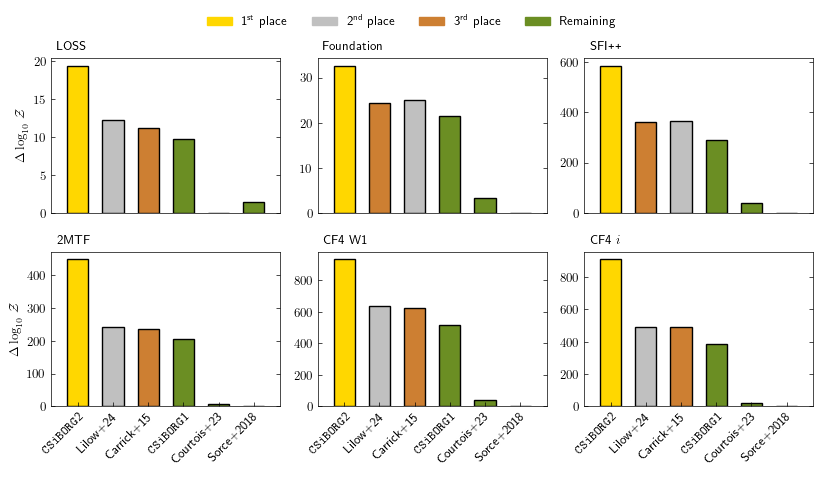

In [17]:
def _top3_colors(vals):
    finite = np.isfinite(vals)
    cols = ["lightgray" if not ok else "olivedrab" for ok in finite]

    if not finite.any():
        return cols  # no winners if column is entirely NaN

    # Rank only finite entries
    order = np.argsort(vals[finite])[::-1]
    idxs = np.where(finite)[0][order]

    if len(idxs) >= 1: cols[idxs[0]] = "#FFD700"  # gold
    if len(idxs) >= 2: cols[idxs[1]] = "#C0C0C0"  # silver
    if len(idxs) >= 3: cols[idxs[2]] = "#CD7F32"  # bronze
    return cols

# Reconstruction names in the same order as rows of gof
rec_names = [name for name, _ in files_here]
Ns = len(rec_names)
assert gof.shape == (Ns, len(samples)), "gof shape must be (Nrec, 6)."

# Make Δlog10 Z per catalogue (column-normalised)
y = gof.copy()                         # (Nrec, 6)

# Plot: always 6 catalogues → 2x3 grid; arbitrary number of reconstructions (bars per panel)
with plt.style.context("science"):
    plt.rcParams.update({"font.size": 9})
    figwidth = 8.3
    fig, axs = plt.subplots(2, 3, figsize=(figwidth, 0.55 * figwidth))
    fig.subplots_adjust(hspace=0, wspace=0)

    x = np.arange(Ns)
    bar_w = 0.6 if Ns <= 8 else 0.45  # a touch narrower if many reconstructions

    for n, cat in enumerate(samples[:6]):
        i, j = divmod(n, 3)
        ax = axs[i, j]

        ax.text(0.025, 1.075, catalogue2label(cat),
                transform=ax.transAxes, va="center", ha="left",
                bbox=dict(facecolor="white", alpha=0.85, edgecolor="none", pad=3),
                zorder=5)

        cols = _top3_colors(y[:, n])
        for xi in range(Ns):
            ax.bar(x[xi], y[xi, n], width=bar_w, color=cols[xi],
                   edgecolor="k", zorder=-1)

        ax.set_xlim(-0.75, Ns - 0.25)

        # x tick labels only on bottom row
        if i == 1:
            ax.set_xticks(np.arange(Ns), [simname2label(s) for s in rec_names],
                          rotation=45, ha="right")
            # nudge labels slightly right
            offset = mtransforms.ScaledTranslation(5 / 72, 0, fig.dpi_scale_trans)
            for lab in ax.get_xticklabels():
                lab.set_transform(lab.get_transform() + offset)
        else:
            ax.set_xticks([], [])

        ax.tick_params(axis="x", which="major", top=False)
        ax.tick_params(axis="x", which="minor", top=False, length=0)
        ax.tick_params(axis="y", which="minor", length=0)

    for i in range(2):
        axs[i, 0].set_ylabel(r"$\Delta \log_{10}\,\mathcal{Z}$")

    # Legend for ranking colors
    gold   = mpatches.Patch(color="#FFD700", label=r"1\textsuperscript{st} place")
    silver = mpatches.Patch(color="#C0C0C0", label=r"2\textsuperscript{nd} place")
    bronze = mpatches.Patch(color="#CD7F32", label=r"3\textsuperscript{rd} place")
    green  = mpatches.Patch(color="olivedrab", label=r"Remaining")
    fig.legend(handles=[gold, silver, bronze, green],
               loc="upper center", bbox_to_anchor=(0.5, 1.05),
               ncol=4, frameon=False)

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/logZ_comparison.pdf", dpi=500)
    fig.show()

### Figure: $\sigma_v$ comparison

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_91176/1807114675.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


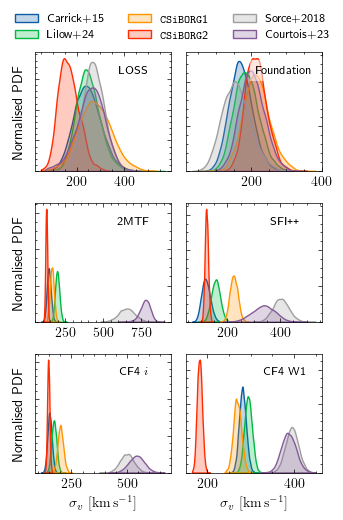

In [23]:
files = switch_paths_SN_to_no_MNR(FILES)

data = load_and_check_posteriors(files, samples, "sigma_v")
sims = ["Carrick2015", "Lilow2024", "CB1", "CB2", "CLONES", "CF4"]
cats = ["LOSS", "Foundation", "2MTF", "SFI", "CF4_i", "CF4_W1"]  # 3 rows × 2 cols

with plt.style.context('science'):

    ncols, nrows = 2, 3
    fig, axs = plt.subplots(nrows, ncols, figsize=(3.5, 3.9 * 1.25))
    fig.subplots_adjust(hspace=0, wspace=0)

    for k, cat in enumerate(cats):
        i, j = divmod(k, ncols)
        ax = axs[i, j]

        for sim in sims:
            arr = data.get((sim, cat))
            if arr is None or np.size(arr) == 0:
                continue
            arr = np.asarray(arr).ravel()
            arr = arr[np.isfinite(arr)]
            if arr.size == 0:
                continue

            sns.kdeplot(
                arr, fill=True, ax=ax,
                clip=(0, np.inf), cut=0,
                color=simname2color(sim),
                label=simname2label(sim) if i == 0 else None
            )

        ax.text(
            0.725, 0.85, catalogue2label(cat),
            transform=ax.transAxes, fontsize="small",
            va='center', ha='center',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
        )
        ax.set_ylabel(None)
        ax.set_yticklabels([])

    # Legend from first row
    handles, labels = axs[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(
            handles, labels, loc='upper center',
            bbox_to_anchor=(0.5, 1.07), ncol=3, frameon=False, fontsize="small"
        )

    # Axes labels
    for c in range(ncols):
        axs[nrows - 1, c].set_xlabel(r"$\sigma_v~[\mathrm{km}\,\mathrm{s}^{-1}]$")
    for r in range(nrows):
        axs[r, 0].set_ylabel("Normalised PDF")

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/sigmav_comparison.pdf", dpi=450, bbox_inches="tight")
    fig.show()

In [24]:
sim = "CF4"
for cat in samples:
    x = data[(sim, cat)] 
    print(f"{cat}: {np.mean(x):3f} +- {np.std(x):3f}")

LOSS: 258.784088 +- 59.333656
Foundation: 202.105850 +- 35.149086
SFI: 336.733521 +- 43.108547
2MTF: 777.000977 +- 33.638138
CF4_W1: 387.298492 +- 16.904041
CF4_i: 542.742615 +- 34.471722


### Figure: $\beta$ comparison

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_91176/3973336747.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


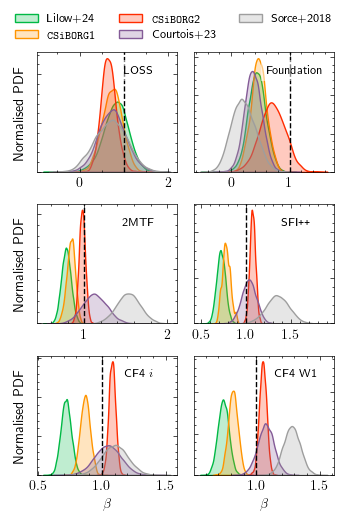

In [26]:
files = replace_token_in_paths(FILES, "_beta_1.0")
files = switch_paths_SN_to_no_MNR(files)
data = load_and_check_posteriors(files, samples, "beta")
sims = ["Lilow2024", "CB1", "CB2", "CF4", "CLONES"]
cats = ["LOSS", "Foundation", "2MTF", "SFI", "CF4_i", "CF4_W1"]  # 3 rows × 2 cols

with plt.style.context('science'):
    ncols, nrows = 2, 3
    fig, axs = plt.subplots(nrows, ncols, figsize=(3.5, 3.9 * 1.25))
    fig.subplots_adjust(hspace=0, wspace=0)

    for k, cat in enumerate(cats):
        i, j = divmod(k, ncols)
        ax = axs[i, j]

        for sim in sims:
            arr = data.get((sim, cat))
            if arr is None or np.size(arr) == 0:
                continue
            arr = np.asarray(arr).ravel()
            arr = arr[np.isfinite(arr)]
            if arr.size == 0:
                continue

            sns.kdeplot(
                arr, fill=True, ax=ax,
                color=simname2color(sim),
                label=simname2label(sim) if i == 0 else None,
            )

        ax.text(
            0.725, 0.85, catalogue2label(cat),
            transform=ax.transAxes, fontsize="small",
            va='center', ha='center',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
        )
        ax.axvline(x=1, color='black', linestyle='--')
        ax.set_ylabel(None)
        ax.set_yticklabels([])

    # Legend from first row
    handles, labels = axs[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(
            handles, labels, loc='upper center',
            bbox_to_anchor=(0.5, 1.07), ncol=3, frameon=False, fontsize="small"
        )

    # Axes labels
    for c in range(ncols):
        axs[nrows - 1, c].set_xlabel(r"$\beta$")
    for r in range(nrows):
        axs[r, 0].set_ylabel("Normalised PDF")

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/beta_comparison.pdf", dpi=450, bbox_inches="tight")
    fig.show()

In [31]:
sim = "CF4"
for cat in samples:
    x = data[(sim, cat)] 
    mu = np.mean(x)
    sigma = np.std(x)
    print(f"{cat}: {mu:2f} +- {sigma:2f} | {(mu - 1) / sigma}")

LOSS: 0.732810 +- 0.318369 | -0.8392482638258325
Foundation: 0.373808 +- 0.151583 | -4.131011759746762
SFI: 1.033589 +- 0.083000 | 0.40469061164035414
2MTF: 1.125242 +- 0.146947 | 0.8522926993890164
CF4_W1: 1.072523 +- 0.065021 | 1.1153775991654435
CF4_i: 1.044435 +- 0.102906 | 0.43179952355291124


### Figure: $V_{\rm ext}$ comparison

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_91176/1967634077.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


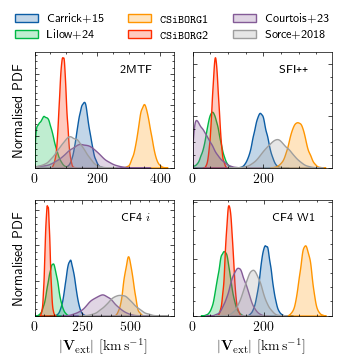

In [32]:
files = switch_paths_SN_to_no_MNR(FILES)
data = load_and_check_posteriors(files, samples, "Vext_mag")
sims = ["Carrick2015", "Lilow2024", "CB1", "CB2", "CF4", "CLONES"]
cats = ["2MTF", "SFI", "CF4_i", "CF4_W1"]


with plt.style.context('science'):
    ncols, nrows = 2, 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(3.5, 2.65 * 1.25))
    fig.subplots_adjust(hspace=0, wspace=0)

    for k, cat in enumerate(cats):
        i, j = divmod(k, ncols)
        ax = axs[i, j]
        for sim in sims:
            arr = data.get((sim, cat))
            if arr is None or np.size(arr) == 0:
                continue
            arr = np.asarray(arr).ravel()
            arr = arr[np.isfinite(arr)]
            if arr.size == 0:
                continue

            sns.kdeplot(
                arr, fill=True, ax=ax,
                clip=(0, np.inf),  # restrict support to [0, ∞)
                cut=0,              # don't extend past the data
                color=simname2color(sim),
                label=simname2label(sim) if i == 0 else None
            )

        ax.text(
            0.725, 0.85, catalogue2label(cat),
            transform=ax.transAxes, fontsize="small",
            va='center', ha='center',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
        )
        ax.set_ylabel(None)
        ax.set_yticklabels([])
        ax.set_xlim(left=0)

    # Legend from first row
    handles, labels = axs[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(
            handles, labels, loc='upper center',
            bbox_to_anchor=(0.5, 1.1), ncol=3, frameon=False,
            fontsize="small")

    for c in range(ncols):
        axs[-1, c].set_xlabel(r"$|\mathbf{V}_{\rm ext}|~[\mathrm{km}\,\mathrm{s}^{-1}]$")
    for r in range(nrows):
        axs[r, 0].set_ylabel("Normalised PDF")

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/Vext_comparison.pdf", dpi=450, bbox_inches="tight")
    fig.show()

In [37]:
sim = "CB1"
for cat in samples:
    x = data[(sim, cat)] 
    mu = np.mean(x)
    sigma = np.std(x)
    print(f"{cat}: {mu:2f} +- {sigma:2f} | {(mu - 0) / sigma}")

LOSS: 338.325500 +- 159.119919 | 2.1262297202659397
Foundation: 222.225052 +- 77.977539 | 2.8498597743866547
SFI: 296.066010 +- 21.555845 | 13.734836465093792
2MTF: 348.754456 +- 19.494318 | 17.89005675477957
CF4_W1: 316.609344 +- 15.462304 | 20.47620730530257
CF4_i: 490.233551 +- 23.578768 | 20.791313425386456


### Bulk flow comparison

In [38]:
root_bf = "/Users/rstiskalek/Projects/CANDEL/data/fields/field_shells"

sims = ["Carrick2015", "Lilow2024", "CB1", "CB2", "CLONES", "CF4",]
cats = ["2MTF", "SFI", "CF4_i", "CF4_W1"]
downsample = 10

bulkflows = {}
for sim, paths in files:
    if sim not in sims:
        continue
    for cat, fname in zip(samples, paths):
        if cat not in cats:
            continue
        key = f"{sim}_{cat}"
        r, B, Borigin = get_bulkflow(fname, sim, root_bf, downsample=downsample)
        bulkflows[key] = {
            "r": r,
            "B": B,
            "Borigin": Borigin,
            "file": fname,
        }


/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_91176/1461106020.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


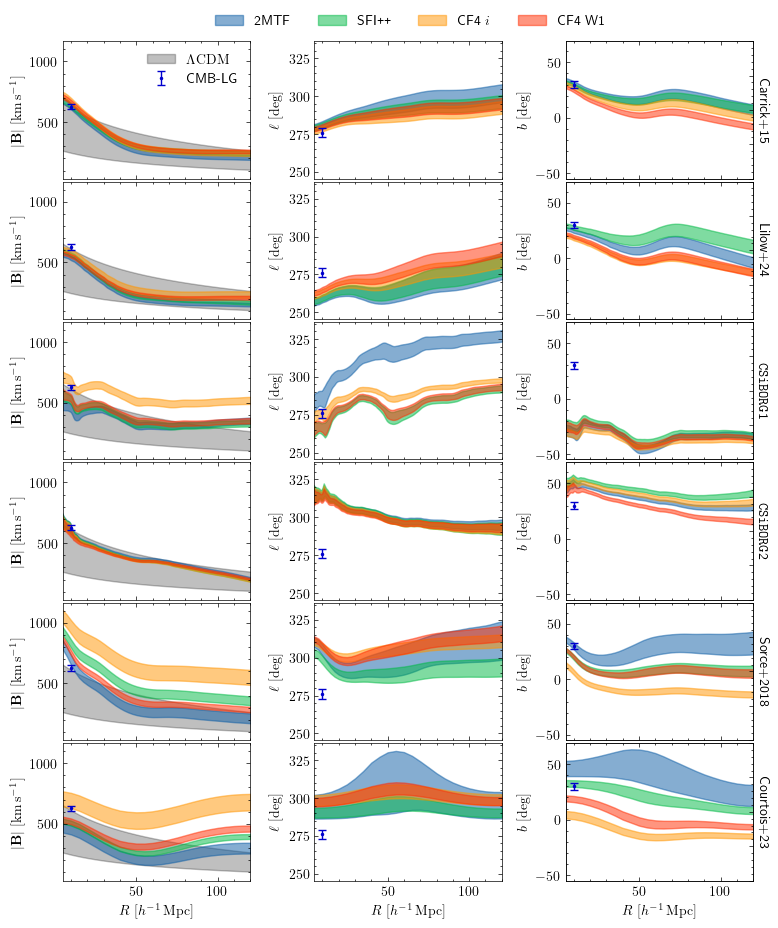

In [41]:
with plt.style.context('science'):
    nrows, ncols = len(sims), 3
    figwidth = 8.3
    fig, axs = plt.subplots(nrows, ncols,
                            figsize=(figwidth, 1.15 * figwidth),
                            sharex=True, sharey="col")
    fig.subplots_adjust(hspace=0, wspace=0)

    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # fill posteriors
    for i, sim in enumerate(sims):
        for j, cat in enumerate(cats):
            key = f"{sim}_{cat}"
            if key not in bulkflows:
                continue
            r = bulkflows[key]["r"]
            B = bulkflows[key]["B"]   # shape (Nr, Nsamp, 3) → |B|, ℓ, b (assumed)
            c = cols[j % len(cols)]

            for n in range(3):
                y16, y50, y84 = np.percentile(B[..., n], [16, 50, 84], axis=-1)
                axs[i, n].fill_between(
                    r, y16, y84, alpha=0.5, color=c, edgecolor=c,
                    label=catalogue2label(cat) if i == 1 and n == 0 else None
                )

    # CMB–LG points (|B|, ℓ, b) at R≈10 Mpc/h
    kwargs = {"color": "mediumblue", "zorder": 10, "capsize": 3, "ms": 1.5}
    for i in range(nrows):
        axs[i, 0].errorbar(10, 627, yerr=22, fmt='o', label="CMB-LG" if i == 0 else None, **kwargs)
        axs[i, 1].errorbar(10, 276, yerr=3,  fmt='o', **kwargs)
        axs[i, 2].errorbar(10, 30,  yerr=3,  fmt='o', **kwargs)

    # ΛCDM expectation band on |B|
    Rs, mean, std, mode, p05, p16, p84, p95 = np.load(
        "/Users/rstiskalek/Projects/CANDEL/data/fields/field_shells/BulkFlowPlot.npy"
    )
    m = Rs < 175
    for i in range(nrows):
        axs[i, 0].fill_between(
            Rs[m], p16[m], p84[m],
            color="black", zorder=0, alpha=0.25,
            label=r"$\Lambda\mathrm{CDM}$" if i == 0 else None
        )

    # axis labels
    for n in range(3):
        axs[-1, n].set_xlabel(r"$R~[h^{-1}\,\mathrm{Mpc}]$")
    for i in range(nrows):
        axs[i, 0].set_ylabel(r"$|\mathbf{B}|~[\mathrm{km}\,\mathrm{s}^{-1}]$")
        axs[i, 1].set_ylabel(r"$\ell~[\mathrm{deg}]$")
        axs[i, 2].set_ylabel(r"$b~[\mathrm{deg}]$")

    # right-side sim labels
    for i, sim in enumerate(sims):
        axr = axs[i, -1].twinx()
        axr.set_ylabel(simname2label(sim), rotation=270, labelpad=7.5)
        axr.set_yticklabels([])

    # x-limits from any available r
    any_key = next(iter(bulkflows))
    r_any = bulkflows[any_key]["r"]
    axs[0, 0].set_xlim(5, 120)

    # legends
    axs[0, 0].legend()
    handles, labels = axs[1, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center',
               bbox_to_anchor=(0.5, 0.975), ncol=len(cats) + 2, frameon=False)

    fig.tight_layout(rect=[0, 0, 0.95, 0.95], h_pad=0.01)
    fig.savefig("/Users/rstiskalek/Downloads/bulkflow_CMB.pdf", dpi=450, bbox_inches="tight")
    fig.show()

Carrick2015 [833.65007885 275.08424212  25.5854343 ] [258.99124342  34.52022786  21.63978702]
Lilow2024 [726.57628356 257.63109622  18.90297324] [259.97724647  43.1533243   25.88239653]
CB1 [840.40902213 252.2971584  -20.74009147] [254.64495103  28.39740903  21.85329878]
CB2 [683.22690468 287.83149513  44.39340139] [170.24066369  44.01908707  15.98086038]
CLONES [1058.96904751  285.55138227   24.5614912 ] [363.06827936  76.78226686  23.93049083]
CF4 [799.25520333 262.60606665  14.41758961] [316.42940857  86.80555593  30.9417635 ]


/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_91176/2666229009.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


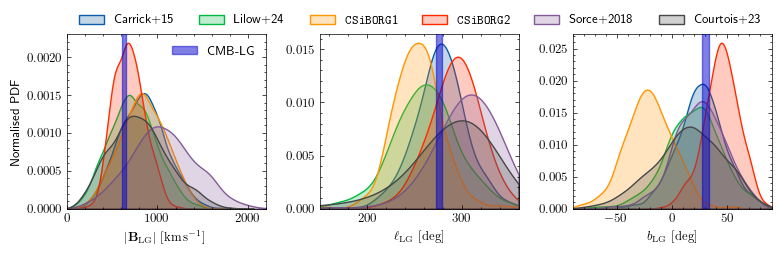

In [43]:
catalogue = "CF4_W1" 
clips = [None, (0, 360), (-90, 90)]

with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})

    nrows, ncols = 1, 3
    figwidth = 8.3
    fig, axs = plt.subplots(nrows, ncols,
                            figsize=(figwidth, 0.3 * figwidth),
                            sharex="col")
    fig.subplots_adjust(hspace=0, wspace=0)
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # KDEs of LG-frame bulk-flow (|B|, l, b) origin samples for the chosen catalogue
    for i, sim in enumerate(sims):
        key = f"{sim}_{catalogue}"
        if key not in bulkflows:
            continue
        B0 = bulkflows[key]["Borigin"]  # shape (..., 3): [|B|, l, b]
        print(sim, B0.mean(axis=0), np.std(B0, axis=0))
        c = cols[i % len(cols)]
        for n in range(3):
            sns.kdeplot(
                B0[..., n], fill=True, ax=axs[n],
                clip=clips[n],
                label=simname2label(sim) if n == 1 else None,
                color=c
            )

    # after plotting, read current y-limits
    ylim0 = axs[0].get_ylim()
    ylim1 = axs[1].get_ylim()
    ylim2 = axs[2].get_ylim()

    # CMB–LG constraints as vertical bands
    band_kwargs = {"color": "mediumblue", "alpha": 0.5, "zorder": 10}
    axs[0].fill_betweenx((ylim0[0], 2 * ylim0[1]), 627 - 22, 627 + 22,
                         label="CMB-LG", **band_kwargs)
    axs[1].fill_betweenx((ylim1[0], 2 * ylim1[1]), 276 - 3, 276 + 3, **band_kwargs)
    axs[2].fill_betweenx((ylim2[0], 2 * ylim2[1]),  30 - 3,  30 + 3, **band_kwargs)

    # Axes labels and limits
    axs[0].set_ylabel(r"Normalised PDF")
    axs[1].set_ylabel(None)
    axs[2].set_ylabel(None)

    axs[0].set_xlim(0, 2200)
    axs[1].set_xlim(150, 360)
    axs[2].set_xlim(-90, 90)

    axs[0].set_ylim(ylim0)
    axs[1].set_ylim(ylim1)
    axs[2].set_ylim(ylim2)

    axs[0].set_xlabel(r"$|\mathbf{B}_{\rm LG}|~[\mathrm{km}\,\mathrm{s}^{-1}]$")
    axs[1].set_xlabel(r"$\ell_{\rm LG}~[\mathrm{deg}]$")
    axs[2].set_xlabel(r"$b_{\rm LG}~[\mathrm{deg}]$")

    axs[0].legend(frameon=False)

    # Global legend (one row, centered above)
    handles, labels = axs[1].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center',
                   bbox_to_anchor=(0.51, 1.02), ncol=len(sims), frameon=False)

    fig.tight_layout(rect=[0, 0, 0.95, 0.95], h_pad=0.01)
    fig.savefig("/Users/rstiskalek/Downloads/bulkflow_origin_CMB.pdf", dpi=450, bbox_inches="tight")
    fig.show()

### Figure: $\beta$ comparison

In [15]:
samples = ["LOSS", "Foundation", "SFI", "2MTF", "CF4_W1", "CF4_i", "CF4_W1,CF4_i,LOSS,Foundation"]
files = [
    ["Carrick2015", [join(root, f"precomputed_los_Carrick2015_{sample}_MNR_linear_from_beta_stochastic.hdf5") for sample in samples]],
    ]

files = switch_paths_SN_to_no_MNR(files)
data = load_and_check_posteriors(files, samples, key="beta")

In [16]:
SIM = "Carrick2015"
TARGET_CATS = ["LOSS", "Foundation", "2MTF", "SFI", "CF4_W1", "CF4_i", "CF4_W1,CF4_i,LOSS,Foundation"]

beta2cosmo = candel.cosmo.Beta2Cosmology(method="juszkiewicz")

rows_beta = []
rows_s8 = []

for cat in TARGET_CATS:
    x = np.asarray(data[(SIM, cat)]).ravel()
    x = x[np.isfinite(x)]
    if x.size == 0:
        continue

    mu_b  = np.mean(x)
    sd_b  = np.std(x, ddof=0)

    s8    = beta2cosmo.compute_S8(x)
    mu_s8 = np.mean(s8)
    sd_s8 = np.std(s8, ddof=0)

    rows_beta.append((catalogue2label(cat), mu_b, sd_b))
    rows_s8.append((catalogue2label(cat), mu_s8, sd_s8))

print("% --- Beta table rows (mean ± std) ---")
for name, mu, sd in rows_beta:
    print(f"{name} & {mu:.3f} $\\pm$ {sd:.3f} \\\\")

print("\n% --- S8 table rows (mean ± std) ---")
for name, mu, sd in rows_s8:
    print(f"{name} & {mu:.3f} $\\pm$ {sd:.3f} \\\\")

% --- Beta table rows (mean ± std) ---
LOSS & 0.412 $\pm$ 0.055 \\
Foundation & 0.433 $\pm$ 0.031 \\
2MTF & 0.439 $\pm$ 0.016 \\
SFI\texttt{++} & 0.407 $\pm$ 0.011 \\
CF4 W1 & 0.451 $\pm$ 0.013 \\
CF4 $i$ & 0.457 $\pm$ 0.013 \\
Joint & 0.456 $\pm$ 0.009 \\

% --- S8 table rows (mean ± std) ---
LOSS & 0.743 $\pm$ 0.093 \\
Foundation & 0.778 $\pm$ 0.057 \\
2MTF & 0.788 $\pm$ 0.038 \\
SFI\texttt{++} & 0.736 $\pm$ 0.033 \\
CF4 W1 & 0.807 $\pm$ 0.035 \\
CF4 $i$ & 0.817 $\pm$ 0.035 \\
Joint & 0.815 $\pm$ 0.032 \\


In [24]:
import posterior_agreement

x = np.random.normal(0.780, 0.034 * 1.05, size=10000)
y = np.random.normal(0.832, 0.013, size=10000)  # Said
# y = np.random.normal(0.36, 0.022o, size=100000)  # Boubel


chains = (x, y)
agreement_1d = posterior_agreement.compute_agreement(chains)

print("p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

p-value 0.174, corresponding to 1.3582 sigmas


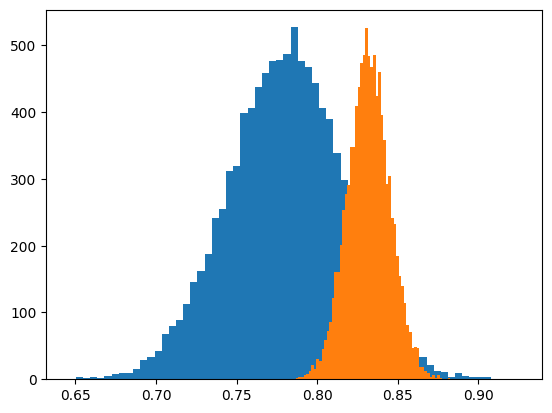

In [26]:
plt.figure()
plt.hist(x, bins="auto")
plt.hist(y, bins="auto")
plt.show()

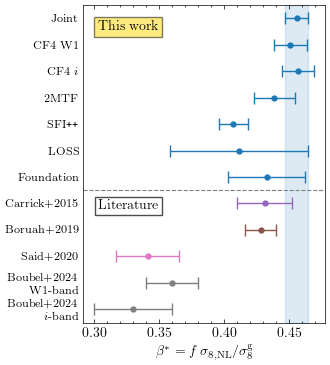

In [74]:
SIM = "Carrick2015"
TARGET_CATS = ["CF4_W1,CF4_i,LOSS,Foundation", "CF4_W1", "CF4_i", "2MTF", "SFI", "LOSS", "Foundation"]

# Collect posterior summaries for this sim
names, xs = [], []
for cat in TARGET_CATS:
    arr = np.asarray(data[(SIM, cat)]).ravel()
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        continue
    names.append(catalogue2label(cat))
    xs.append(arr)

# Compute mean and 16–84th percentiles
mean  = [np.mean(x) for x in xs]
lower = [np.percentile(x, 16) for x in xs]
upper = [np.percentile(x, 84) for x in xs]

# Add literature references
lit_names = [
    "Carrick+2015", "Boruah+2019", "Said+2020",
    "Boubel+2024\nW1-band", "Boubel+2024\n$i$-band"
]
lit_means = [0.431, 0.428, 0.341, 0.36, 0.33]
lit_errs  = [0.021, 0.012, 0.024, 0.02, 0.03]

names.extend(lit_names)
mean.extend(lit_means)
lower.extend([m - e for m, e in zip(lit_means, lit_errs)])
upper.extend([m + e for m, e in zip(lit_means, lit_errs)])

# Error bars
y_err_lower = np.array(mean) - np.array(lower)
y_err_upper = np.array(upper) - np.array(mean)

# Colors: "this work" in same colour, literature in distinct colours
cols = sns.color_palette()
colors = [cols[0]] * len(xs) + [cols[4], cols[5], cols[6], cols[7], cols[7]]

# --- Plot ---
with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(3.5, 3.5 * 1.1))

    divider = len(xs) + 0.5
    ax.axhline(divider, color="gray", linestyle="dashed", lw=0.8)

    for i, (name, mu, el, eu, color) in enumerate(zip(names, mean, y_err_lower, y_err_upper, colors), start=1):
        ax.errorbar(mu, i, xerr=[[el], [eu]], fmt="o",
                    color=color, capsize=4, ms=3.5)
        if i == 1:  # highlight first entry of "This work"
            ax.fill_betweenx([0.5, len(names) + 0.5],
                             mu - el, mu + eu, color=color, alpha=0.15)

    ax.set_yticks(range(1, len(names) + 1), names, fontsize="small")
    ax.tick_params(axis="y", which="both", length=0)
    ax.set_xlabel(r"$\beta^* = f\,\sigma_{8,\mathrm{NL}} / \sigma_8^{\rm g}$")
    ax.set_ylim(0.5, len(names) + 0.5)
    ax.invert_yaxis()

    ax.text(0.06, 0.95, f"This work",
            ha="left", va="top", weight="bold", transform=ax.transAxes,
            bbox=dict(facecolor="gold", edgecolor="black", alpha=0.5, pad=2.5))
    ax.text(0.06, (len(xs)+1)/len(names) -0.3, "Literature",
            ha="left", va="center", weight="bold", transform=ax.transAxes, bbox=dict(facecolor="white", edgecolor="black", alpha=0.7, pad=2.0))

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/C15_beta.pdf", dpi=450, bbox_inches="tight")
    plt.show()

In [75]:
lit_means = [0.431, 0.428, 0.341, 0.36, 0.33]
lit_errs  = [0.021, 0.012, 0.024, 0.02, 0.03]


x = np.hstack([np.random.normal(0.36, 0.02, 100000),
               np.random.normal(0.33, 0.03, 10000)
               ])

In [76]:
x = beta2cosmo.compute_S8(x)

In [77]:
x.mean(), x.std()

(0.632096330492313, 0.04388674830255661)

Building SR interpolator: 100%|██████████| 100/100 [00:00<00:00, 137.81it/s]


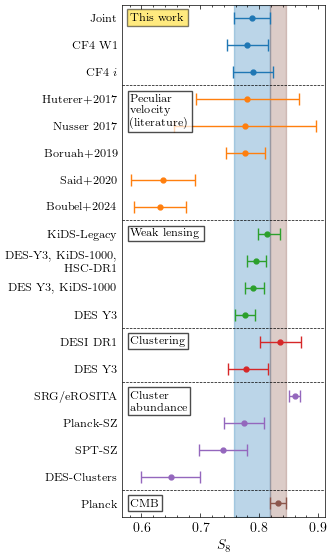

In [78]:
beta2cosmo = candel.cosmo.Beta2Cosmology()

SIM = "Carrick2015"
TARGET_CATS = ["CF4_W1,CF4_i,LOSS,Foundation", "CF4_W1", "CF4_i"] 
data = load_and_check_posteriors(files, samples, key="beta")

this_names = []
this_S8    = []

for cat in TARGET_CATS:
    beta = np.asarray(data[(SIM, cat)]).ravel()
    beta = beta[np.isfinite(beta)]
    if beta.size == 0:
        continue
    S8 = beta2cosmo.compute_S8(beta)  # vector -> vector
    this_names.append(catalogue2label(cat))
    this_S8.append(S8)

# Summaries
means_this = [np.mean(x) for x in this_S8]
errs_this  = [(np.percentile(x, 16), np.percentile(x, 84)) for x in this_S8]

# ---- literature blocks ----
lit_blocks = {
    "pv": [
        ("Huterer+2017", 0.780, 0.087),
        ("Nusser 2017",  0.776, 0.120),
        ("Boruah+2019",  0.776, 0.033),
        ("Said+2020",    0.637, 0.054),
        ("Boubel+2024",    0.632, 0.044),
    ],
    "wl": [
        ("KiDS-Legacy",        0.814, (0.016, 0.021)),
        ("DES-Y3, KiDS-1000,\nHSC-DR1", 0.795, (0.015, 0.017)),
        ("DES Y3, KiDS-1000", 0.790, (0.014, 0.018)),
        ("DES Y3",             0.776, 0.017),

    ],
    "clustering": [
        ("DESI DR1", 0.836, 0.035),
        ("DES Y3",   0.778, (0.031, 0.037)),
    ],
    "clusters": [
        ("SRG/eROSITA",  0.86, 0.01),
        ("Planck-SZ",    0.774, 0.034),
        ("SPT-SZ",       0.739, 0.041),
        ("DES-Clusters", 0.650, 0.050),
    ],
    "cmb": [
        ("Planck", 0.832, 0.013),
    ],
}

# Flatten literature lists
lit_names = []
lit_means = []
lit_errs  = []
for group in ["pv", "wl", "clustering", "clusters", "cmb"]:
    for name, m, s in lit_blocks[group]:
        lit_names.append(name)
        lit_means.append(m)
        lit_errs.append(s)

# Convert (possibly asymmetric) errs to (lower, upper) bounds around mean
def _to_bounds(means, errs):
    lows, ups = [], []
    for m, e in zip(means, errs):
        if isinstance(e, tuple):
            lows.append(m - e[0])
            ups.append(m + e[1])
        else:
            lows.append(m - e)
            ups.append(m + e)
    return lows, ups

# Combine all names/means/bounds
names = this_names + lit_names
means = means_this + lit_means
lower_this = [a for a, _ in errs_this]
upper_this = [b for _, b in errs_this]
lower_lit, upper_lit = _to_bounds(lit_means, lit_errs)
lower = lower_this + lower_lit
upper = upper_this + upper_lit

# Errors for errorbar()
err_lo = np.array(means) - np.array(lower)
err_hi = np.array(upper) - np.array(means)

# Colors per block
cols = sns.color_palette()
n_this = len(this_names)
n_pv   = len(lit_blocks["pv"])
n_wl   = len(lit_blocks["wl"])
n_cl   = len(lit_blocks["clustering"])
n_cls  = len(lit_blocks["clusters"])
n_cmb  = len(lit_blocks["cmb"])

colors = (
    [cols[0]] * n_this +
    [cols[1]] * n_pv +
    [cols[2]] * n_wl +
    [cols[3]] * n_cl +
    [cols[4]] * n_cls +
    [cols[5]] * n_cmb
)

# Horizontal divider positions (between sections)
b1 = n_this + 0.5
b2 = b1 + n_pv
b3 = b2 + n_wl
b4 = b3 + n_cl
b5 = b4 + n_cls

with plt.style.context("science"):
    fig = plt.figure(figsize=(3.5, 2.625 * 2.2))
    ax = fig.add_subplot(111)

    # Spine style for consistent divider look
    col_spine = ax.spines["bottom"].get_edgecolor()
    lw_spine  = ax.spines["bottom"].get_linewidth()

    # --- Plot points with horizontal error bars ---
    for i, (name, mu, lo, hi, color) in enumerate(zip(names, means, err_lo, err_hi, colors), start=1):
        ax.errorbar(mu, i, xerr=[[lo], [hi]], fmt="o",
                    color=color, capsize=4, ms=3.5)
        # Optional highlight of the first "This work" entry
        if i == 1 or name == "Planck":
            ax.fill_betweenx([0.5, len(names) + 0.5], mu - lo, mu + hi,
                             color=color, alpha=0.3)

    # --- Automated section dividers & labels ---
    # Block sizes in row counts (must match how you built `names`)
    # n_this, n_pv, n_wl, n_cl, n_cls, n_cmb are integers
    block_sizes = [n_this, n_pv, n_wl, n_cl, n_cls, n_cmb]
    block_labels = [
        f"This work",
        "Peculiar\nvelocity\n(literature)",
        "Weak lensing",
        "Clustering",
        "Cluster\nabundance",
        "CMB",
    ]

    # Draw dashed dividers between blocks
    cumulative = np.cumsum(block_sizes)
    dividers_y = cumulative[:-1] + 0.5
    for y in dividers_y:
        ax.axhline(y, color=col_spine, linestyle="dashed", lw=lw_spine)
    
    # Compute TOP-inside positions for labels (accounting for inverted y)
    starts = np.concatenate(([0], cumulative[:-1]))   # 0, n_this, n_this+n_pv, ...
    eps = 0.3                                        # small offset inside the block
    tops_y = starts + 0.5 + eps                       # just below the divider line
    
    # Place labels using axes-x + data-y transform
    tform = ax.get_yaxis_transform()  # axes x (0..1), data y
    for y, label in zip(tops_y, block_labels):
        # Skip empty blocks (size 0)
        if y - eps == (starts + 0.5)[list(block_labels).index(label)] and block_sizes[list(block_labels).index(label)] == 0:
            continue
        
        boxprops = dict(facecolor="white", edgecolor="black", alpha=0.7, pad=2.0)
        if label.startswith("This work"):
            boxprops = dict(facecolor="gold", edgecolor="black", alpha=0.5, pad=2.5)
    
        ax.text(
            0.04, y, label, transform=tform,
            ha="left", va="top",                # align top of the box at y
            weight="bold", color=col_spine, fontsize="small",
            bbox=boxprops
        )
        
    # --- Axis cosmetics ---
    ax.set_yticks(range(1, len(names) + 1), names, fontsize="small")
    ax.tick_params(axis="y", which="both", length=0)
    ax.set_xlabel(r"$S_8$")
    ax.set_ylim(0.5, len(names) + 0.5)
    ax.invert_yaxis()

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/S8_comparison.pdf", dpi=450, bbox_inches="tight")
    plt.show()